In [22]:
# ========================================
# 1. IMPORTAR LIBRERÍAS
# ========================================
import cv2
import numpy as np
import cupy as cp
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import time
from google.colab import drive
import os

print("🎯 Librerías importadas exitosamente")

🎯 Librerías importadas exitosamente


In [23]:
# ========================================
# 2. DESCARGAR VIDEO DE PRUEBA

# ========================================

#print("\n📥 Descargando video de prueba...")


#video_path = "/content/sky (1).mp4"
#output_video = "/content/output_grayscale.mp4"

In [24]:
# ========================================
# 3. KERNEL CUDA PARA CONVERSIÓN A ESCALA DE GRISES
# ========================================
kernel_grayscale = '''
extern "C"
__global__ void rgb_to_grayscale(const unsigned char *input, unsigned char *output, int rows, int cols) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < cols && y < rows) {
        int idx = (y * cols + x) * 3;
        int out_idx = y * cols + x;

        unsigned char b = input[idx];
        unsigned char g = input[idx + 1];
        unsigned char r = input[idx + 2];

        output[out_idx] = (unsigned char)(0.114f * b + 0.587f * g + 0.299f * r);
    }
}
'''

In [25]:
# ========================================
# 4. KERNEL CUDA PARA SUSTRACCIÓN DE FONDO
# ========================================
kernel_background_sub = '''
extern "C"
__global__ void background_subtraction(const unsigned char *frame, const unsigned char *background,
                                       unsigned char *diff, int rows, int cols) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < cols && y < rows) {
        int idx = y * cols + x;
        int frame_val = frame[idx];
        int bg_val = background[idx];
        int diff_val = abs(frame_val - bg_val);
        diff[idx] = (unsigned char)min(255, diff_val);
    }
}
'''

In [26]:
# ========================================
# 5. KERNEL CUDA PARA UMBRALIZACIÓN
# ========================================
kernel_threshold = '''
extern "C"
__global__ void thresholding(const unsigned char *input, unsigned char *output, int rows, int cols, int threshold) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < cols && y < rows) {
        int idx = y * cols + x;
        output[idx] = (input[idx] > threshold) ? 255 : 0;
    }
}
'''

# Compilar kernels
try:
    module_grayscale = cp.RawModule(code=kernel_grayscale)
    rgb_to_grayscale = module_grayscale.get_function('rgb_to_grayscale')

    module_bg = cp.RawModule(code=kernel_background_sub)
    background_subtraction = module_bg.get_function('background_subtraction')

    module_thresh = cp.RawModule(code=kernel_threshold)
    thresholding = module_thresh.get_function('thresholding')

    print("✅ Kernels CUDA compilados exitosamente")
except Exception as e:
    print(f"⚠️ Error compilando kernels: {e}")

✅ Kernels CUDA compilados exitosamente


In [27]:
# ========================================
# 6. CLASE PRINCIPAL: ASTEROID DETECTOR
# ========================================
class AsteroidDetector:
    def __init__(self, video_path, threshold=50, block_size=(16, 16)):
        self.video_path = video_path
        self.threshold = threshold
        self.block_size = block_size
        self.asteroid_detected = False
        self.trajectory_data = []

        # Cargar propiedades del video
        cap = cv2.VideoCapture(video_path)
        self.width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = int(cap.get(cv2.CAP_PROP_FPS))
        self.total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        # Calcular grid
        self.grid_size = (
            (self.width + self.block_size[0] - 1) // self.block_size[0],
            (self.height + self.block_size[1] - 1) // self.block_size[1]
        )

        print(f"📹 Video: {self.width}x{self.height} @ {self.fps}fps ({self.total_frames} frames)")
        print(f"🔧 CUDA Grid: {self.grid_size} bloques, {self.block_size} threads/bloque\n")

    def convert_to_grayscale_gpu(self, frame_bgr):
        """Convertir frame a escala de grises en GPU"""
        frame_gpu = cp.asarray(frame_bgr)
        gray_gpu = cp.zeros((self.height, self.width), dtype=cp.uint8)

        rgb_to_grayscale(
            grid=self.grid_size,
            block=self.block_size,
            args=(frame_gpu.data.ptr, gray_gpu.data.ptr, cp.int32(self.height), cp.int32(self.width))
        )
        cp.cuda.Stream.null.synchronize()
        return cp.asnumpy(gray_gpu)

    def create_background_model(self):
        """Crear imagen de fondo usando apilamiento de mediana"""
        print("⏳ Creando modelo de fondo (Median Stacking)...")

        cap = cv2.VideoCapture(self.video_path)
        frames_gray = []
        frame_idx = 0

        # Cargar todos los frames en escala de grises
        while cap.isOpened() and frame_idx < self.total_frames:
            ret, frame = cap.read()
            if not ret:
                break

            gray = self.convert_to_grayscale_gpu(frame)
            frames_gray.append(gray)

            if frame_idx % max(1, self.total_frames // 10) == 0:
                print(f"  ✓ Cargados {frame_idx}/{self.total_frames} frames")
            frame_idx += 1

        cap.release()

        # Stack en GPU usando CuPy
        print("  Calculando mediana en GPU...")
        frames_gpu = cp.array(frames_gray, dtype=cp.uint8)
        background_gpu = cp.median(frames_gpu, axis=0).astype(cp.uint8)
        background = cp.asnumpy(background_gpu)

        print("✅ Modelo de fondo creado\n")
        return background

    def detect_asteroid(self, background):
        """Detectar asteroide realizando sustracción de fondo"""
        print("⏳ Detectando asteroide (Background Subtraction)...")

        cap = cv2.VideoCapture(self.video_path)
        frame_idx = 0

        start_time = time.time()

        while cap.isOpened() and frame_idx < self.total_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir a escala de grises
            gray = self.convert_to_grayscale_gpu(frame)

            # Sustracción de fondo en GPU
            frame_gpu = cp.asarray(gray)
            bg_gpu = cp.asarray(background)
            diff_gpu = cp.zeros_like(frame_gpu)

            background_subtraction(
                grid=self.grid_size,
                block=self.block_size,
                args=(frame_gpu.data.ptr, bg_gpu.data.ptr, diff_gpu.data.ptr,
                      cp.int32(self.height), cp.int32(self.width))
            )
            cp.cuda.Stream.null.synchronize()

            # Umbralización en GPU
            diff = cp.asnumpy(diff_gpu)
            thresh_gpu = cp.zeros_like(diff_gpu)

            thresholding(
                grid=self.grid_size,
                block=self.block_size,
                args=(diff_gpu.data.ptr, thresh_gpu.data.ptr, cp.int32(self.height),
                      cp.int32(self.width), cp.int32(self.threshold))
            )
            cp.cuda.Stream.null.synchronize()

            thresh = cp.asnumpy(thresh_gpu)

            # Encontrar píxeles del asteroide
            asteroid_pixels = np.where(thresh > 0)

            if len(asteroid_pixels[0]) > 0:
                self.asteroid_detected = True
                # Calcular centroide
                y_mean = np.mean(asteroid_pixels[0])
                x_mean = np.mean(asteroid_pixels[1])
                self.trajectory_data.append((frame_idx, x_mean, y_mean))

            frame_idx += 1

            if frame_idx % max(1, self.total_frames // 10) == 0:
                print(f"  ✓ Procesados {frame_idx}/{self.total_frames} frames")

        cap.release()
        end_time = time.time()

        print(f"✅ Detección completada en {end_time - start_time:.2f}s\n")

    def generate_report(self):
        """Generar reporte de detección"""
        print("=" * 60)
        print("📊 REPORTE DE DETECCIÓN DE ASTEROIDES")
        print("=" * 60)

        if self.asteroid_detected and len(self.trajectory_data) > 0:
            print(f"✅ VEREDICTO: Existe Asteroide")
            print(f"📍 Detecciones: {len(self.trajectory_data)} frames con asteroide")
            print(f"🎯 Rango de coordenadas X: {min(d[1] for d in self.trajectory_data):.1f} - {max(d[1] for d in self.trajectory_data):.1f}")
            print(f"🎯 Rango de coordenadas Y: {min(d[2] for d in self.trajectory_data):.1f} - {max(d[2] for d in self.trajectory_data):.1f}")
        else:
            print(f"❌ VEREDICTO: No Existe Asteroide")

        print("=" * 60 + "\n")

    def plot_trajectory(self):
        """Graficar trayectoria del asteroide"""
        fig, ax = plt.subplots(figsize=(12, 8))

        if self.asteroid_detected and len(self.trajectory_data) > 0:
            frames, x_coords, y_coords = zip(*self.trajectory_data)

            # Scatter plot con color según tiempo
            scatter = ax.scatter(x_coords, y_coords, c=frames, cmap='viridis', s=100, alpha=0.6, edgecolors='white')

            # Línea de trayectoria
            ax.plot(x_coords, y_coords, 'r--', alpha=0.5, linewidth=2, label='Trayectoria')

            # Anotaciones
            ax.set_xlabel('Posición X (píxeles)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Posición Y (píxeles)', fontsize=12, fontweight='bold')
            ax.set_title('Trayectoria del Asteroide Detectado', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)

            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Número de Frame', fontsize=10)

        else:
            ax.text(0.5, 0.5, 'No se detectó asteroide',
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14, color='red', fontweight='bold')
            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_xlabel('Posición X (píxeles)', fontsize=12)
            ax.set_ylabel('Posición Y (píxeles)', fontsize=12)
            ax.set_title('Fondo Estelar - Sin Asteroide Detectado', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig('/content/trajectory_plot.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("💾 Gráfica guardada en '/content/trajectory_plot.png'\n")

    def overlay_trajectory_on_frame(self):
        """Superponer trayectoria detectada en un frame del video"""
        print("🎬 Superponiendo trayectoria en frame del video...")

        # Obtener frame del medio del video
        cap = cv2.VideoCapture(self.video_path)
        middle_frame_idx = self.total_frames // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)

        ret, frame = cap.read()
        cap.release()

        if not ret:
            print("❌ Error al leer frame")
            return

        # Convertir a RGB para visualización
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Crear figura con el frame
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.imshow(frame_rgb)

        if self.asteroid_detected and len(self.trajectory_data) > 0:
            frames, x_coords, y_coords = zip(*self.trajectory_data)

            # Dibujar línea de trayectoria
            ax.plot(x_coords, y_coords, 'r-', linewidth=3, label='Trayectoria', alpha=0.8)

            # Dibujar puntos de trayectoria con gradiente de color
            scatter = ax.scatter(x_coords, y_coords, c=frames, cmap='plasma', s=150,
                               alpha=0.7, edgecolors='white', linewidth=2, zorder=5)

            # Marcar inicio con verde
            ax.plot(x_coords[0], y_coords[0], 'go', markersize=15, label='Inicio',
                   markeredgecolor='white', markeredgewidth=2, zorder=6)

            # Marcar fin con rojo
            ax.plot(x_coords[-1], y_coords[-1], 'r^', markersize=15, label='Fin',
                   markeredgecolor='white', markeredgewidth=2, zorder=6)

            # Colorbar
            cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
            cbar.set_label('Número de Frame', fontsize=11, fontweight='bold')

            # Información en la imagen
            info_text = f"Frame procesado: {middle_frame_idx}\nDetecciones: {len(self.trajectory_data)}"
            ax.text(10, 30, info_text, fontsize=11, color='yellow', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7),
                   verticalalignment='top')
        else:
            ax.text(0.5, 0.5, 'No se detectó asteroide',
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=16, color='red', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))

        ax.set_xlabel('Posición X (píxeles)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Posición Y (píxeles)', fontsize=12, fontweight='bold')
        ax.set_title(f'Trayectoria Superpuesta en Frame {middle_frame_idx}',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.2, color='white', linestyle='--')

        plt.tight_layout()
        plt.savefig('/content/trajectory_overlay.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("💾 Overlay guardado en '/content/trajectory_overlay.png'\n")


In [28]:
# ========================================
# 7. PROCESADOR DE MÚLTIPLES VIDEOS
# ========================================
class MultiVideoProcessor:
    def __init__(self, base_path="/content", num_videos=6, threshold=50):
        self.base_path = base_path
        self.num_videos = num_videos
        self.threshold = threshold
        self.results = []

    def process_all_videos(self):
        """Procesar múltiples videos en secuencia"""
        print("\n" + "="*70)
        print("🚀 PROCESANDO MÚLTIPLES VIDEOS")
        print("="*70 + "\n")

        for i in range(1, self.num_videos + 1):
            if i == 1:
                video_name = "sky.mp4"
            else:
                video_name = f"sky{i}.mp4"

            video_path = os.path.join(self.base_path, video_name)

            print(f"\n{'='*70}")
            print(f"📹 VIDEO {i}/{self.num_videos}: {video_name}")
            print(f"{'='*70}")

            # Verificar si el video existe
            if not os.path.exists(video_path):
                print(f"⚠️ Video no encontrado: {video_path}")
                self.results.append({
                    'video': video_name,
                    'numero': i,
                    'estado': 'NO ENCONTRADO',
                    'asteroide_detectado': False,
                    'detecciones': 0,
                    'tiempo_procesamiento': 0
                })
                continue

            start_process = time.time()

            try:
                # Crear detector
                detector = AsteroidDetector(video_path, threshold=self.threshold)

                # Paso 1: Crear modelo de fondo
                print(f"\n[Video {i}] Creando modelo de fondo...")
                background = detector.create_background_model()

                # Paso 2: Detectar asteroide
                print(f"[Video {i}] Detectando asteroide...")
                detector.detect_asteroid(background)

                end_process = time.time()
                tiempo_total = end_process - start_process

                # Paso 3: Generar reporte
                print(f"[Video {i}] Generando reporte...")
                detector.generate_report()

                # Paso 4: Graficar trayectoria
                print(f"[Video {i}] Generando gráficas...")
                detector.plot_trajectory()

                # Paso 5: Superponer trayectoria en frame del video
                detector.overlay_trajectory_on_frame()

                # Guardar resultado
                self.results.append({
                    'video': video_name,
                    'numero': i,
                    'estado': 'PROCESADO ✅',
                    'asteroide_detectado': detector.asteroid_detected,
                    'detecciones': len(detector.trajectory_data),
                    'tiempo_procesamiento': tiempo_total
                })

                print(f"\n✅ Video {i} completado en {tiempo_total:.2f}s")

            except Exception as e:
                print(f"\n❌ Error procesando video {i}: {str(e)}")
                self.results.append({
                    'video': video_name,
                    'numero': i,
                    'estado': f'ERROR: {str(e)}',
                    'asteroide_detectado': False,
                    'detecciones': 0,
                    'tiempo_procesamiento': 0
                })

    def generate_summary_report(self):
        """Generar reporte resumen de todos los videos"""
        print("\n\n" + "="*70)
        print("📊 REPORTE RESUMEN - PROCESAMIENTO DE 6 VIDEOS")
        print("="*70 + "\n")

        print(f"{'Video':<15} {'Estado':<20} {'Asteroide':<15} {'Detecciones':<15} {'Tiempo (s)':<12}")
        print("-" * 77)

        asteroides_encontrados = 0
        total_tiempo = 0

        for result in self.results:
            asteroide_str = "✅ SÍ" if result['asteroide_detectado'] else "❌ NO"
            estado = result['estado']

            print(f"{result['video']:<15} {estado:<20} {asteroide_str:<15} "
                  f"{result['detecciones']:<15} {result['tiempo_procesamiento']:<12.2f}")

            if result['asteroide_detectado']:
                asteroides_encontrados += 1

            total_tiempo += result['tiempo_procesamiento']

        print("-" * 77)
        print(f"\n📈 ESTADÍSTICAS GENERALES:")
        print(f"   • Total de videos procesados: {len([r for r in self.results if r['estado'] == 'PROCESADO ✅'])}")
        print(f"   • Videos con asteroide detectado: {asteroides_encontrados}")
        print(f"   • Videos sin asteroide: {len([r for r in self.results if not r['asteroide_detectado'] and r['estado'] == 'PROCESADO ✅'])}")
        print(f"   • Tiempo total de procesamiento: {total_tiempo:.2f}s")
        print(f"   • Tiempo promedio por video: {total_tiempo / len([r for r in self.results if r['estado'] == 'PROCESADO ✅']):.2f}s"
              if len([r for r in self.results if r['estado'] == 'PROCESADO ✅']) > 0 else "")
        print("="*70 + "\n")

        # Guardar reporte en archivo
        self.save_report_to_file()

    def save_report_to_file(self):
        """Guardar reporte en archivo de texto"""
        report_path = "/content/reporte_completo.txt"

        with open(report_path, 'w') as f:
            f.write("="*70 + "\n")
            f.write("REPORTE COMPLETO - DETECCIÓN DE ASTEROIDES EN 6 VIDEOS\n")
            f.write("="*70 + "\n\n")

            for result in self.results:
                asteroide_str = "SÍ - ASTEROIDE DETECTADO" if result['asteroide_detectado'] else "NO - SIN ASTEROIDE"

                f.write(f"Video: {result['video']}\n")
                f.write(f"Número: {result['numero']}\n")
                f.write(f"Estado: {result['estado']}\n")
                f.write(f"Resultado: {asteroide_str}\n")
                f.write(f"Detecciones: {result['detecciones']}\n")
                f.write(f"Tiempo: {result['tiempo_procesamiento']:.2f}s\n")
                f.write("-"*70 + "\n\n")

        print(f"💾 Reporte guardado en: {report_path}")


🚀 PROCESANDO MÚLTIPLES VIDEOS


📹 VIDEO 1/6: sky.mp4
📹 Video: 686x1030 @ 30fps (240 frames)
🔧 CUDA Grid: (43, 65) bloques, (16, 16) threads/bloque


[Video 1] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 1] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 frames
✅ Detección completada en 1.46s

[Video 1] Generando r

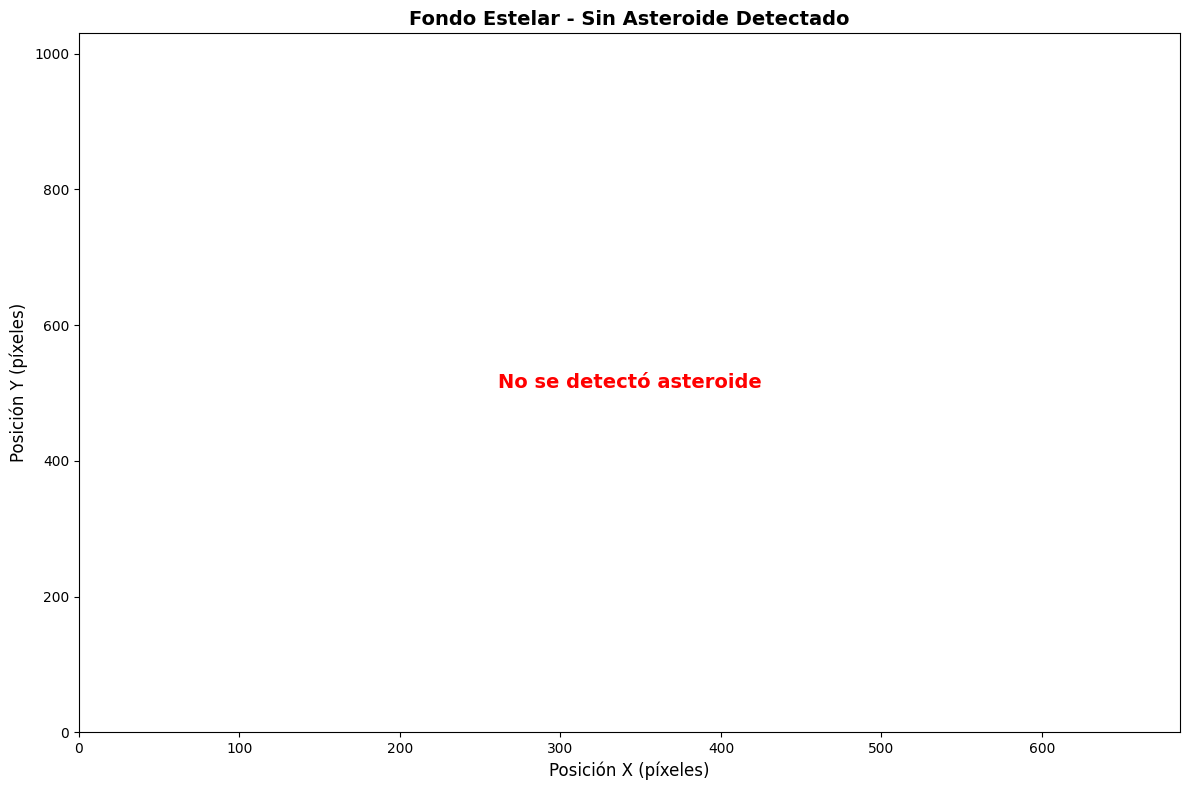

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


/tmp/ipython-input-841307959.py:252: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=11, framealpha=0.9)


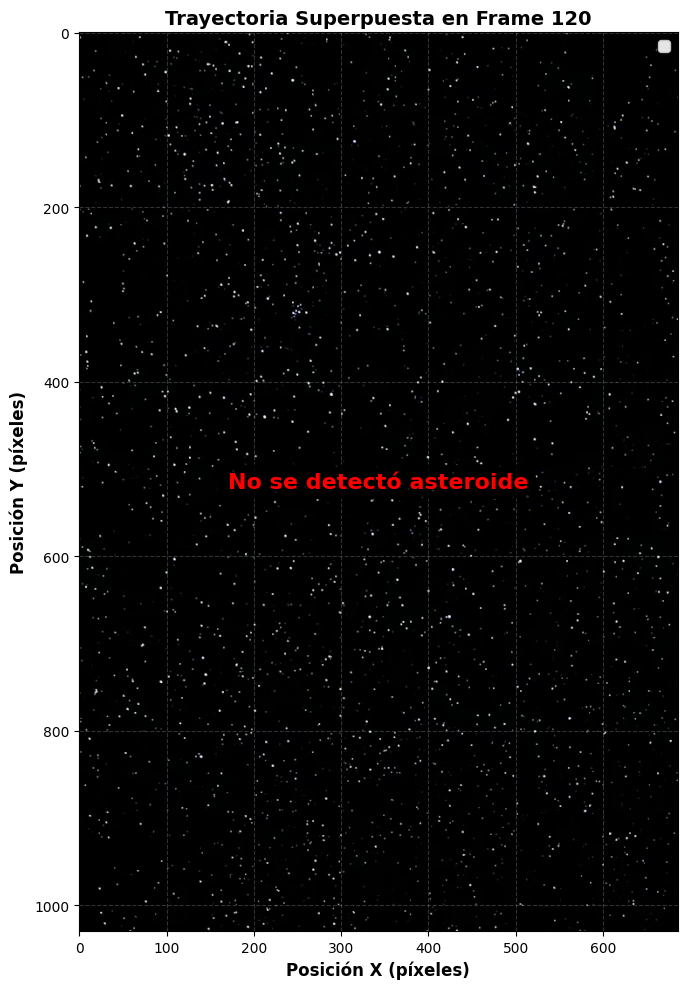

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 1 completado en 2.61s

📹 VIDEO 2/6: sky2.mp4
📹 Video: 686x1030 @ 30fps (240 frames)
🔧 CUDA Grid: (43, 65) bloques, (16, 16) threads/bloque


[Video 2] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 2] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 fram

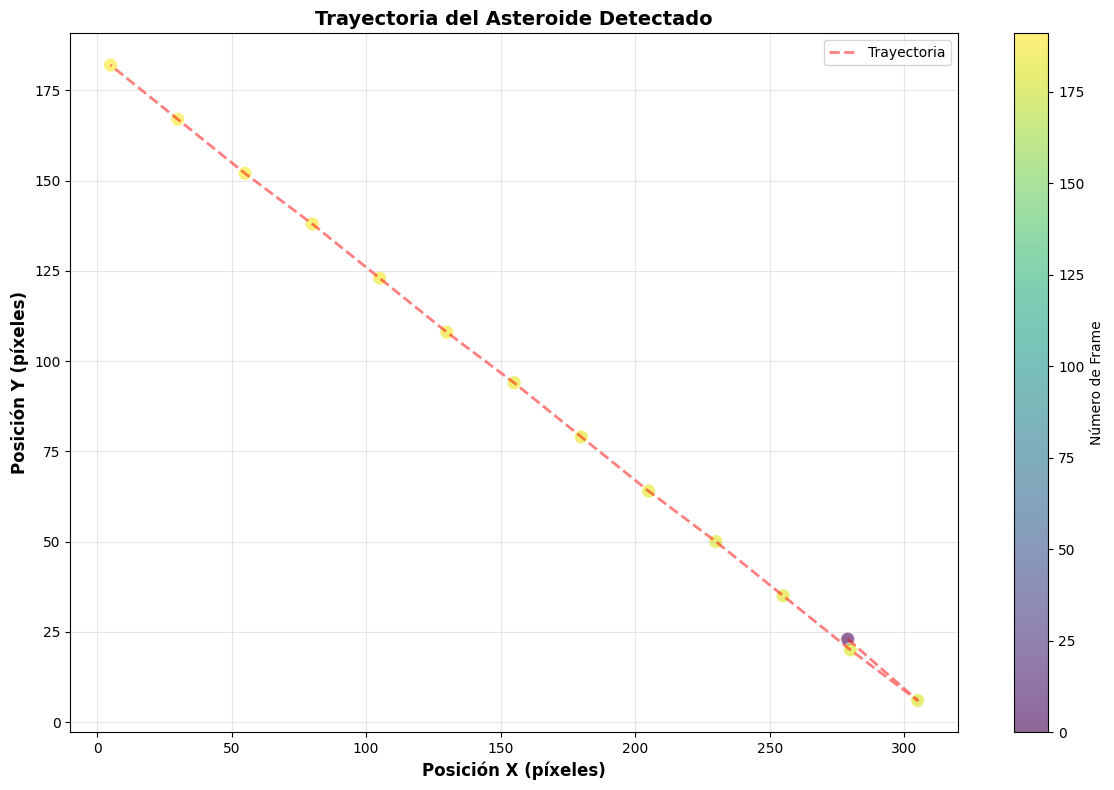

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


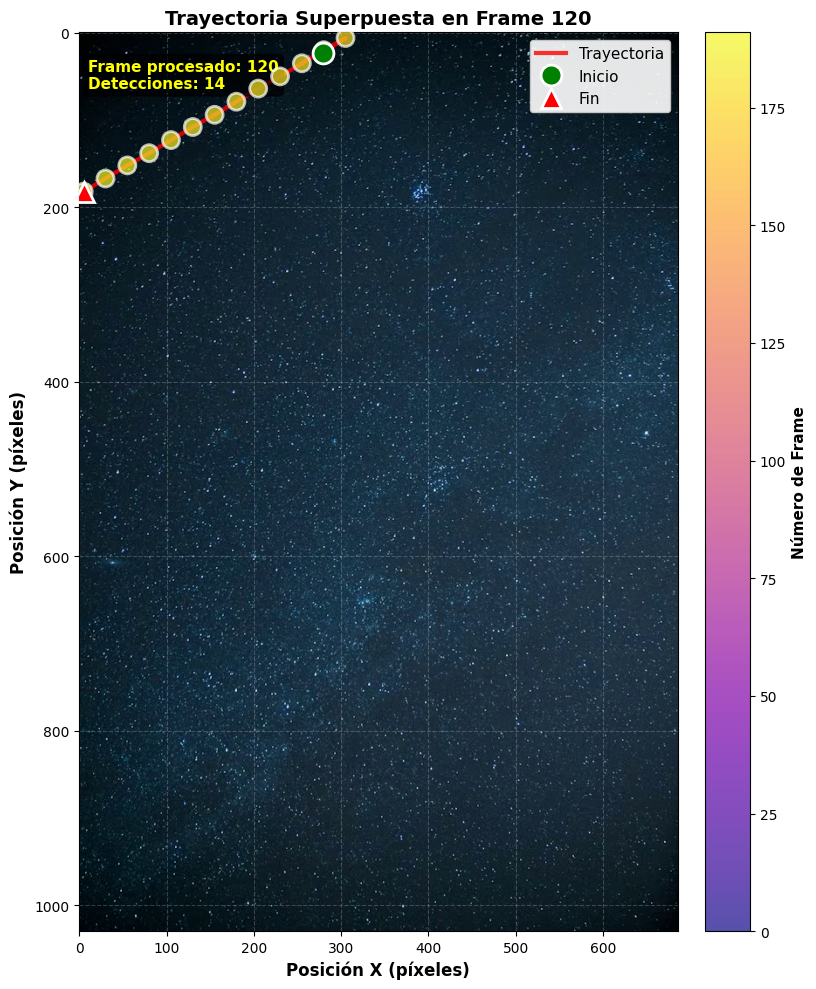

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 2 completado en 2.29s

📹 VIDEO 3/6: sky3.mp4
📹 Video: 1150x784 @ 30fps (240 frames)
🔧 CUDA Grid: (72, 49) bloques, (16, 16) threads/bloque


[Video 3] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 3] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 fram

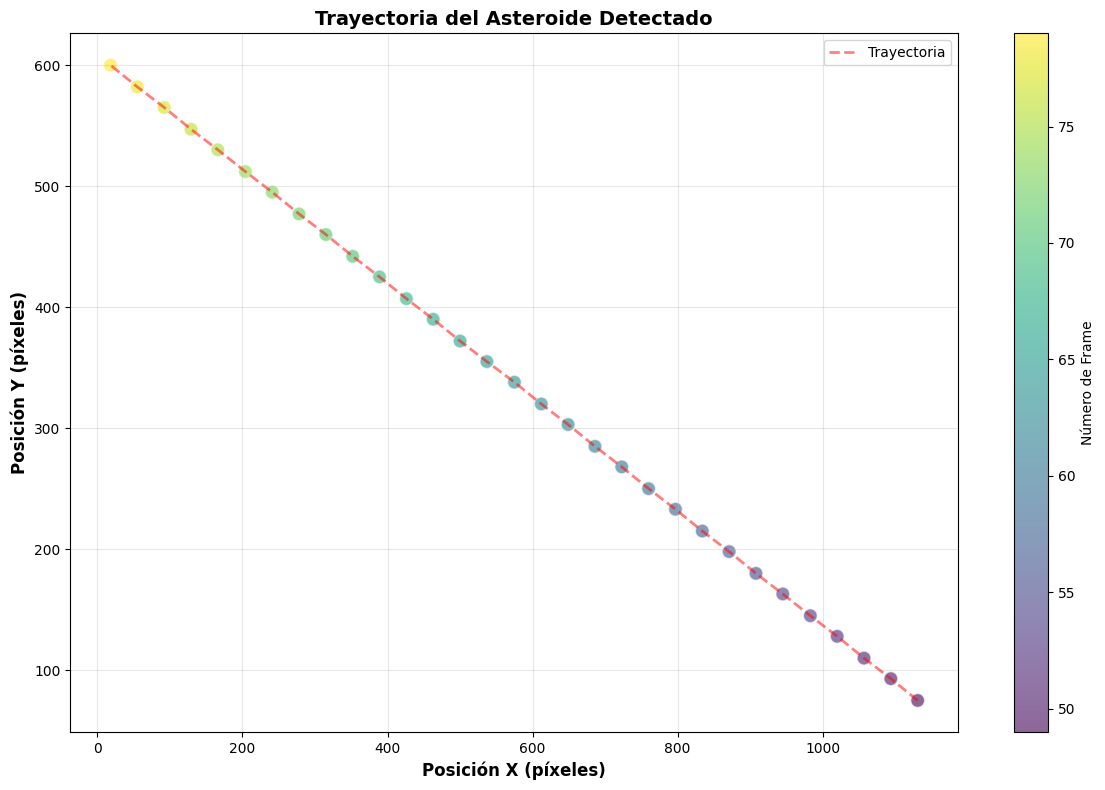

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


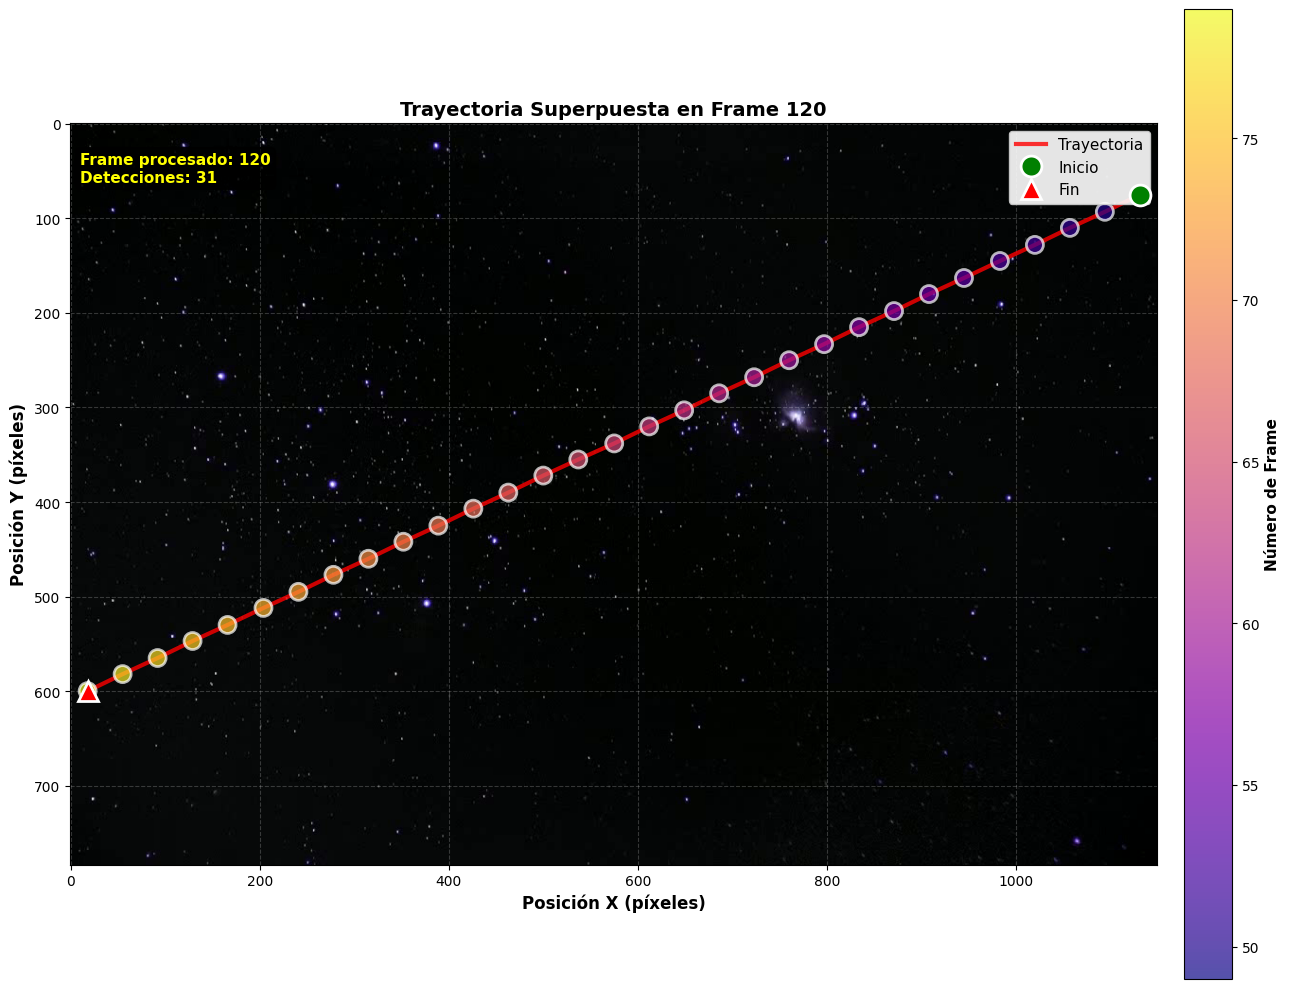

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 3 completado en 2.91s

📹 VIDEO 4/6: sky4.mp4
📹 Video: 1170x780 @ 30fps (240 frames)
🔧 CUDA Grid: (74, 49) bloques, (16, 16) threads/bloque


[Video 4] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 4] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 fram

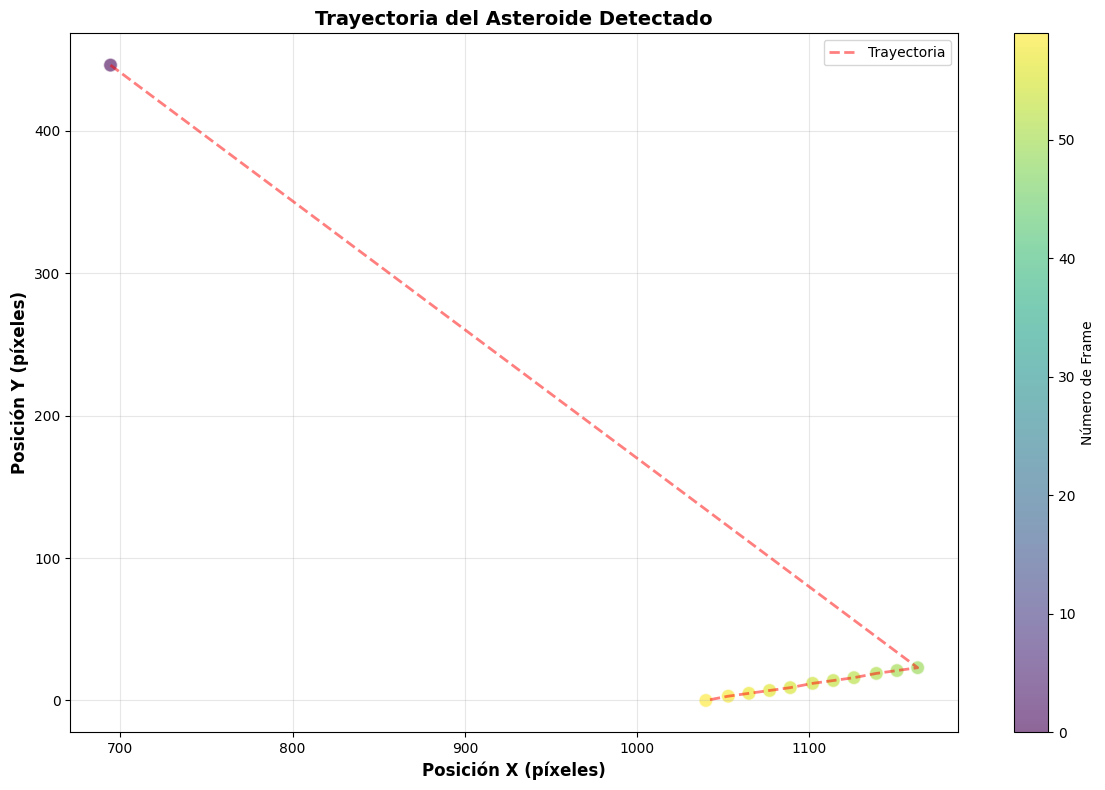

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


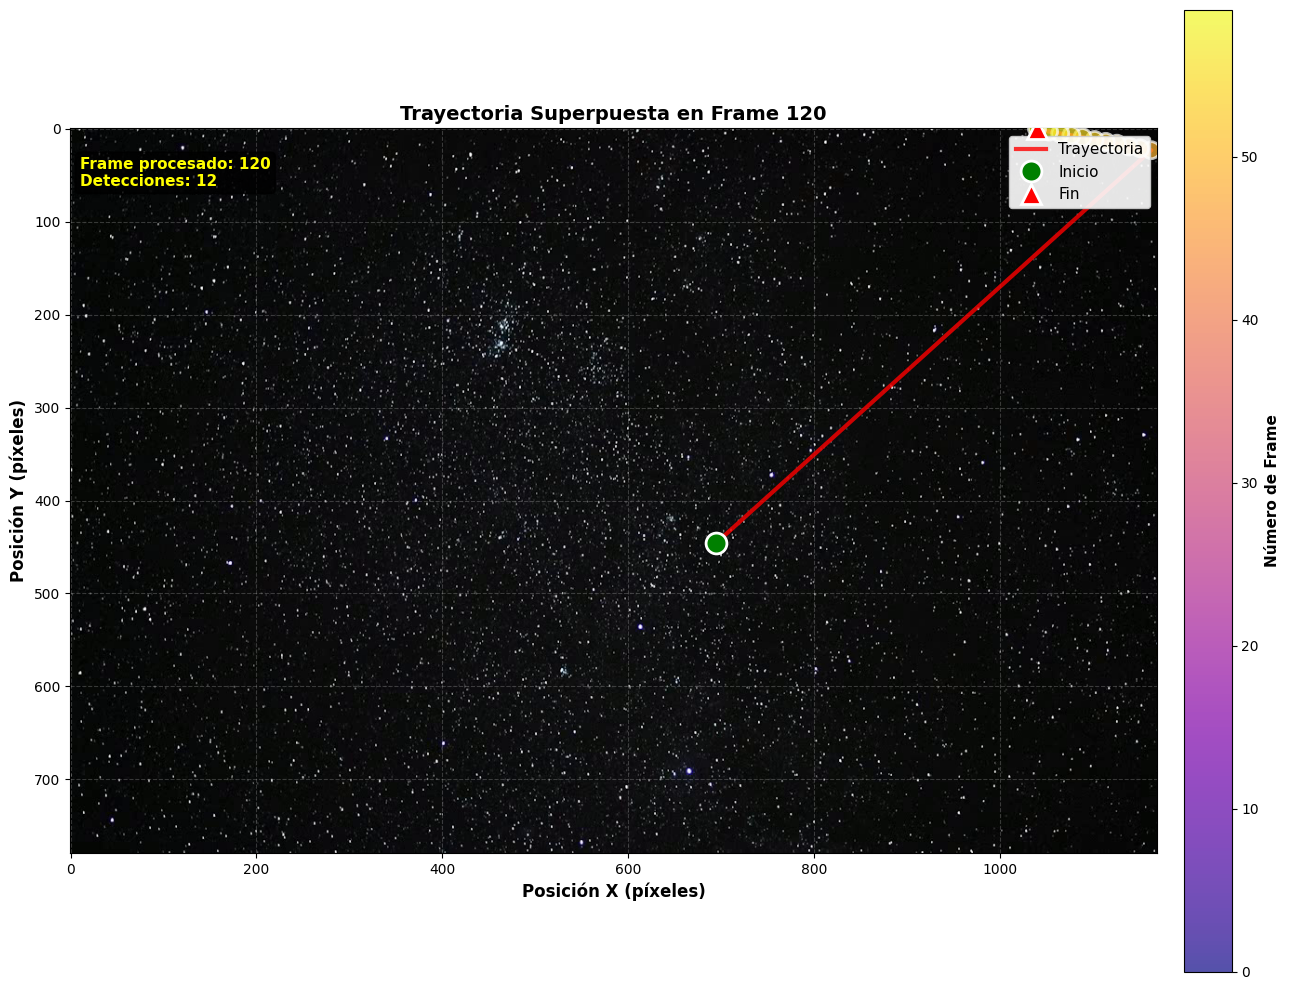

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 4 completado en 3.38s

📹 VIDEO 5/6: sky5.mp4
📹 Video: 686x1030 @ 30fps (240 frames)
🔧 CUDA Grid: (43, 65) bloques, (16, 16) threads/bloque


[Video 5] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 5] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 fram

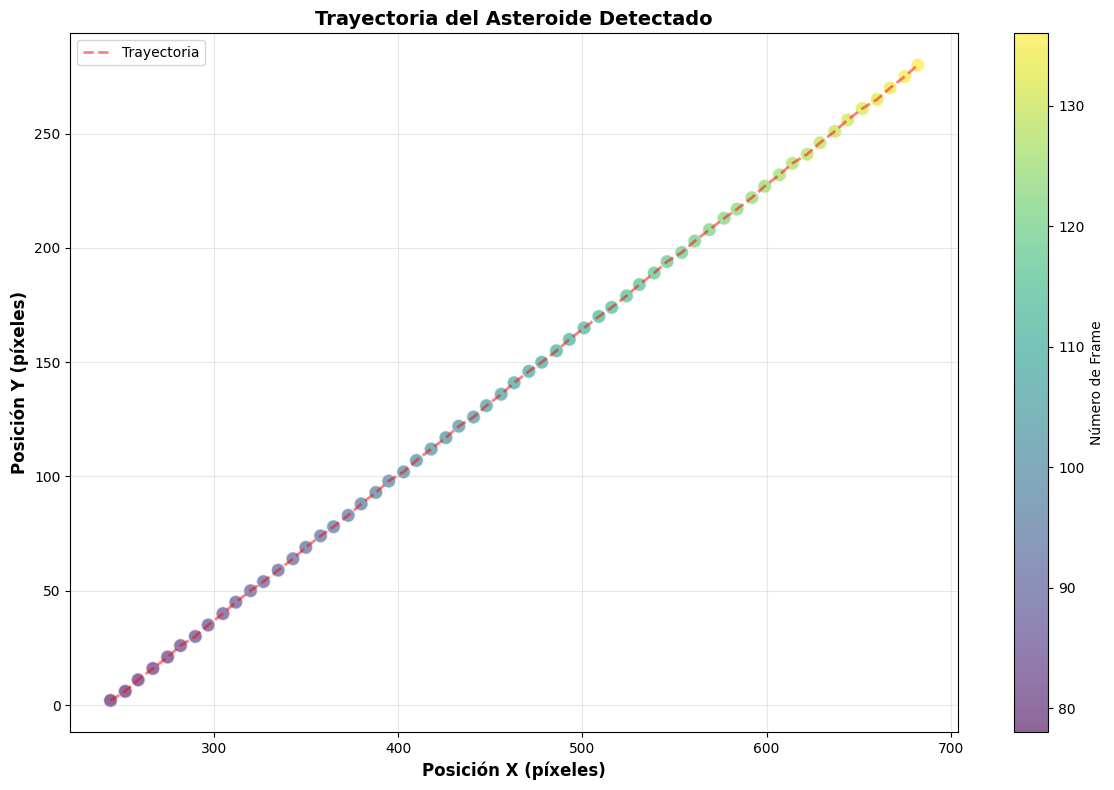

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


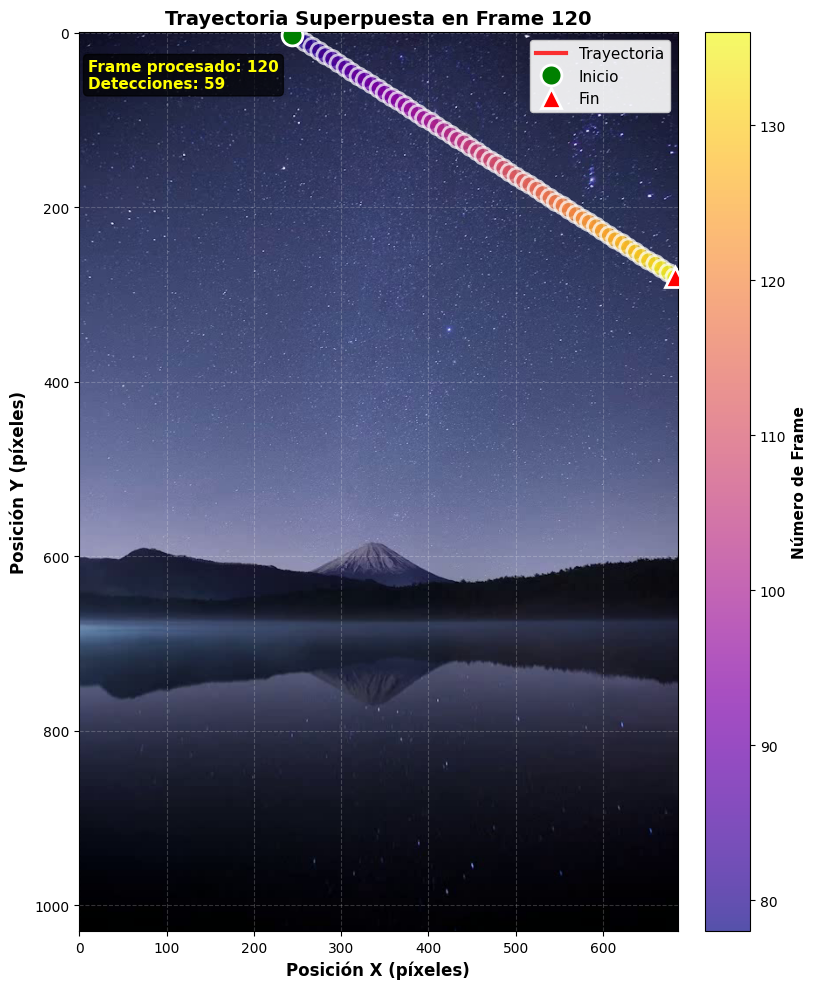

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 5 completado en 2.36s

📹 VIDEO 6/6: sky6.mp4
📹 Video: 1170x780 @ 30fps (240 frames)
🔧 CUDA Grid: (74, 49) bloques, (16, 16) threads/bloque


[Video 6] Creando modelo de fondo...
⏳ Creando modelo de fondo (Median Stacking)...
  ✓ Cargados 0/240 frames
  ✓ Cargados 24/240 frames
  ✓ Cargados 48/240 frames
  ✓ Cargados 72/240 frames
  ✓ Cargados 96/240 frames
  ✓ Cargados 120/240 frames
  ✓ Cargados 144/240 frames
  ✓ Cargados 168/240 frames
  ✓ Cargados 192/240 frames
  ✓ Cargados 216/240 frames
  Calculando mediana en GPU...
✅ Modelo de fondo creado

[Video 6] Detectando asteroide...
⏳ Detectando asteroide (Background Subtraction)...
  ✓ Procesados 24/240 frames
  ✓ Procesados 48/240 frames
  ✓ Procesados 72/240 frames
  ✓ Procesados 96/240 frames
  ✓ Procesados 120/240 frames
  ✓ Procesados 144/240 frames
  ✓ Procesados 168/240 frames
  ✓ Procesados 192/240 frames
  ✓ Procesados 216/240 frames
  ✓ Procesados 240/240 fram

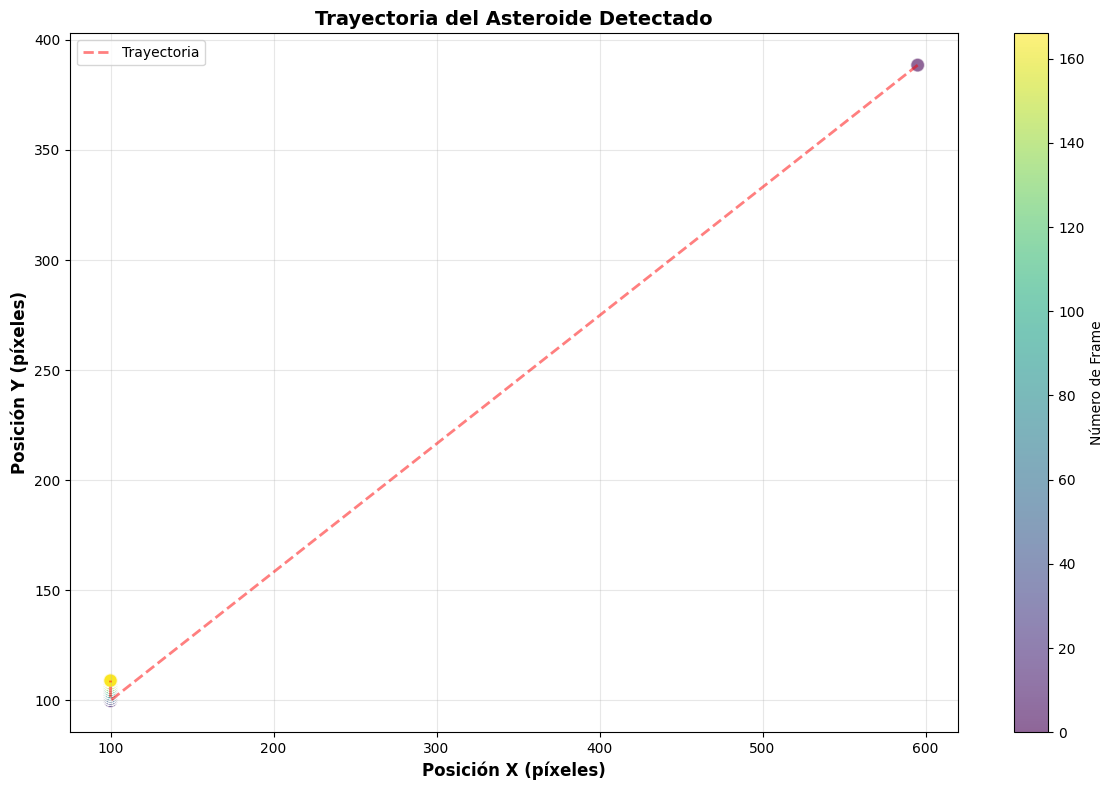

💾 Gráfica guardada en '/content/trajectory_plot.png'

🎬 Superponiendo trayectoria en frame del video...


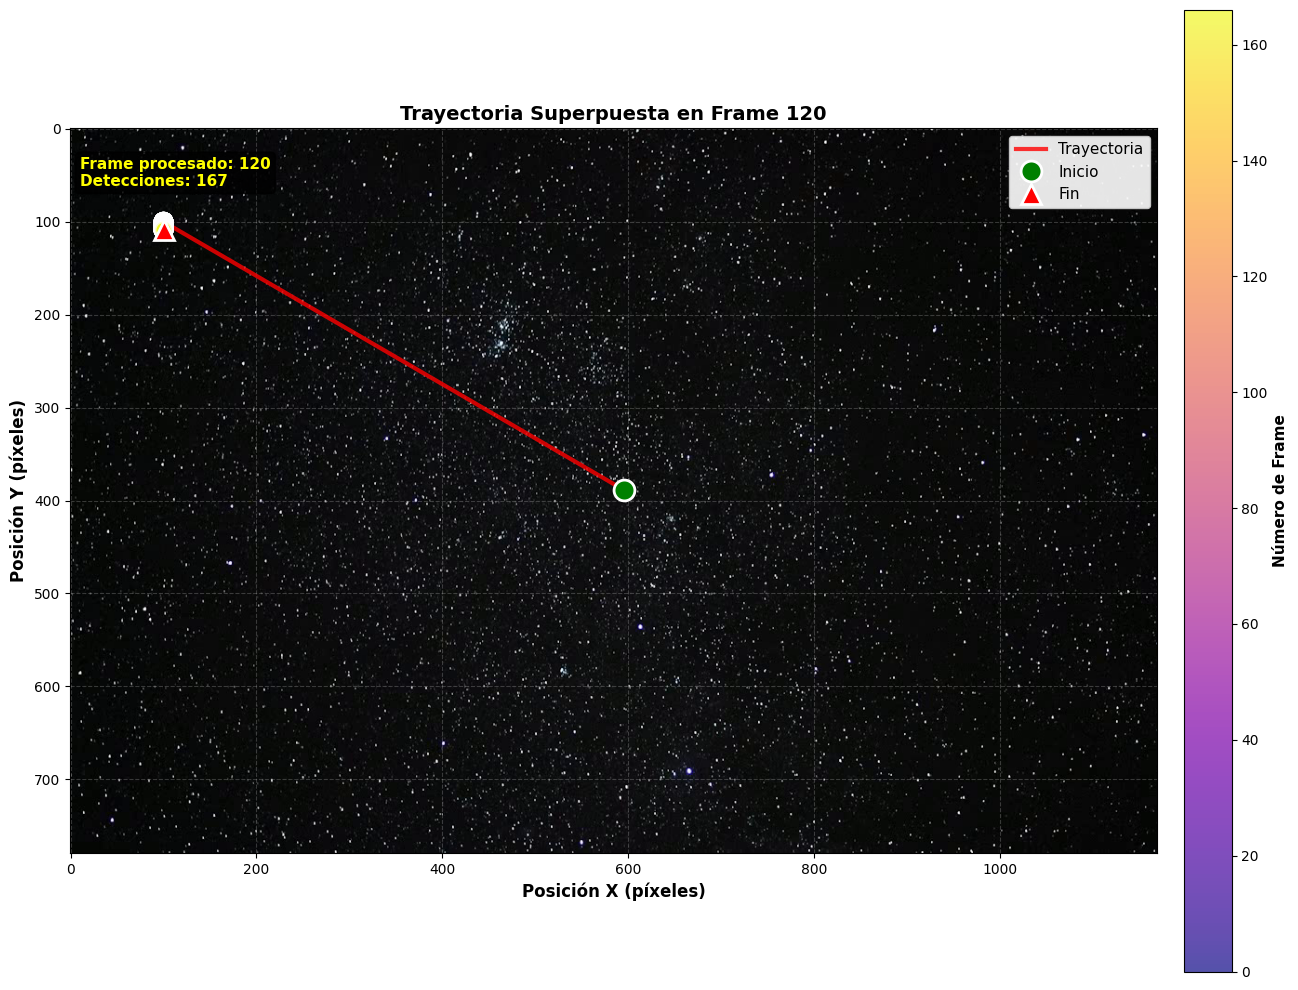

💾 Overlay guardado en '/content/trajectory_overlay.png'


✅ Video 6 completado en 3.00s


📊 REPORTE RESUMEN - PROCESAMIENTO DE 6 VIDEOS

Video           Estado               Asteroide       Detecciones     Tiempo (s)  
-----------------------------------------------------------------------------
sky.mp4         PROCESADO ✅          ❌ NO            0               2.61        
sky2.mp4        PROCESADO ✅          ✅ SÍ            14              2.29        
sky3.mp4        PROCESADO ✅          ✅ SÍ            31              2.91        
sky4.mp4        PROCESADO ✅          ✅ SÍ            12              3.38        
sky5.mp4        PROCESADO ✅          ✅ SÍ            59              2.36        
sky6.mp4        PROCESADO ✅          ✅ SÍ            167             3.00        
-----------------------------------------------------------------------------

📈 ESTADÍSTICAS GENERALES:
   • Total de videos procesados: 6
   • Videos con asteroide detectado: 5
   • Videos sin asteroide: 1
   

In [29]:
# ========================================
# 10. EJECUCIÓN PRINCIPAL
# ========================================
# Crear procesador de múltiples videos
processor = MultiVideoProcessor(base_path="/content", num_videos=6, threshold=50)

# Procesar todos los videos
processor.process_all_videos()

# Generar reporte resumen
processor.generate_summary_report()

print("✅ PROCESAMIENTO COMPLETO DE TODOS LOS VIDEOS FINALIZADO")